In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms 
from torchvision.datasets import ImageFolder
import timm

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\bruno\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CatsDogsDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [4]:
dataset = CatsDogsDataset(
    data_dir='./train_data'
)

0


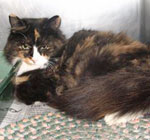

In [5]:
image, label = dataset[100]
print(label)
image

In [6]:
print(dataset.classes)

['Cat', 'Dog']


In [7]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = './train_data'
dataset = CatsDogsDataset(data_dir, transform)

In [8]:
image, label = dataset[0]
image.shape

torch.Size([3, 128, 128])

In [9]:
# iterate over dataset
for image, label in dataset:
    break

In [10]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
for images, labels in dataloader:
    break

In [12]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [13]:
class CatsDogsClassifer(nn.Module):
    def __init__(self, num_classes=2):
        super(CatsDogsClassifer, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [14]:
model = CatsDogsClassifer(num_classes=2)

In [15]:
example_out = model(images)
example_out.shape 

torch.Size([32, 2])

In [16]:
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # optimizer

In [17]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 2]) torch.Size([32])


In [18]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = './train_data/'
test_folder = './test_data/'

train_dataset = CatsDogsDataset(train_folder, transform=transform)
test_dataset = CatsDogsDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
# Simple training loop
num_epochs = 3
train_losses, val_losses = [], []

model = CatsDogsClassifer(num_classes=2)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Move inputs and labels to the device
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    

    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}")

Epoch 1/3 - Train loss: 0.17477158406565382
Epoch 2/3 - Train loss: 0.08853260149713364
Epoch 3/3 - Train loss: 0.06463991845252338


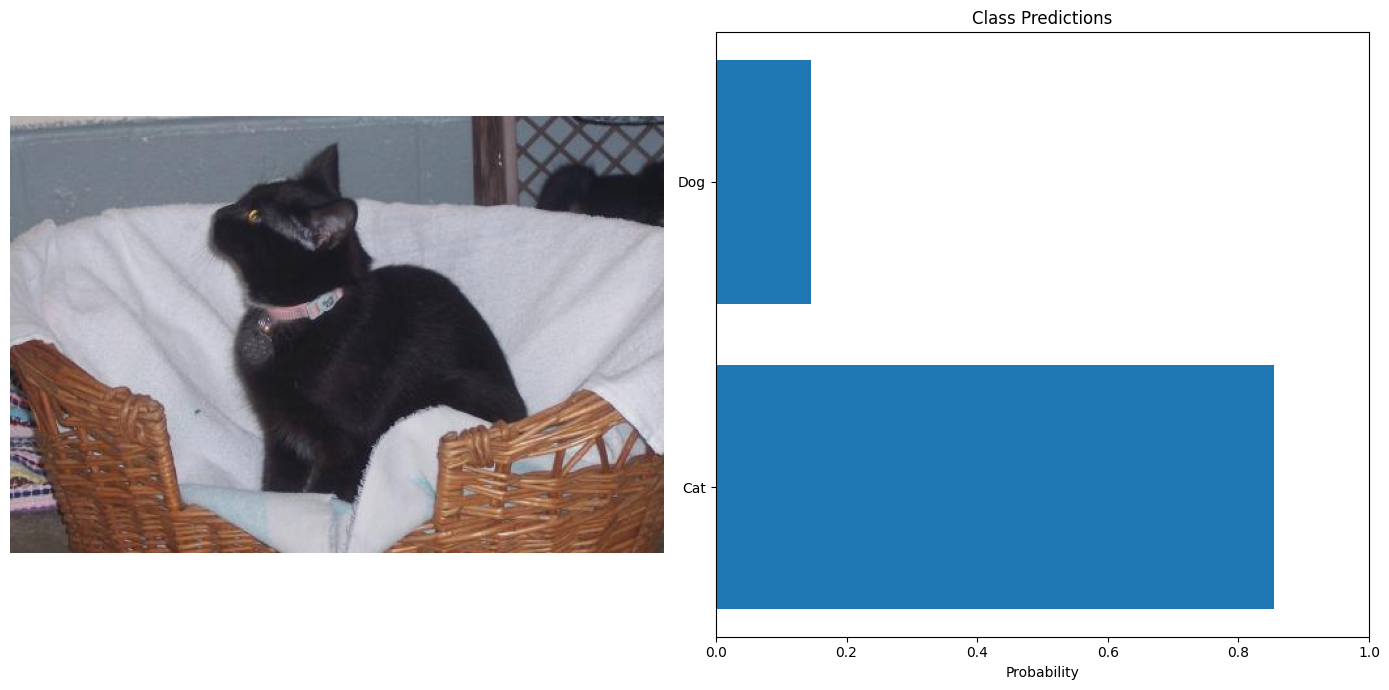

In [22]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# Example usage
test_image = "./test_data/Cat/1145.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor)

# Assuming dataset.classes gives the class names
class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

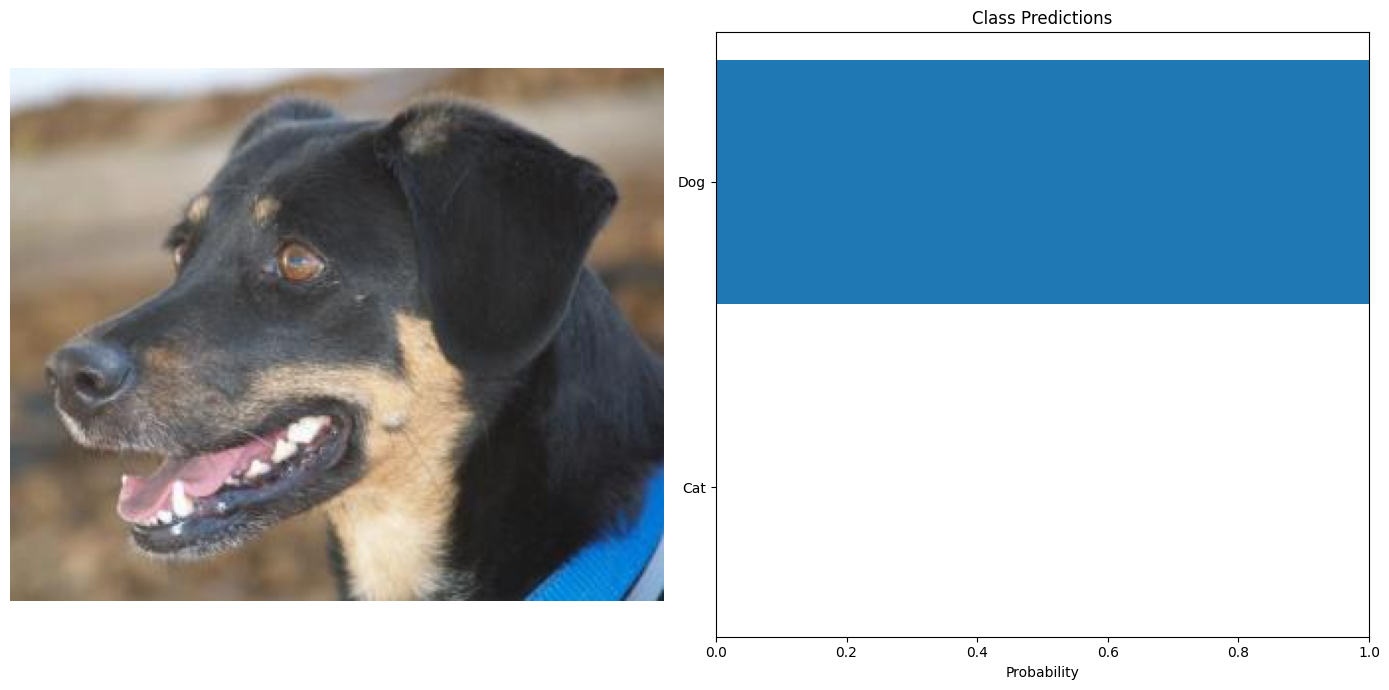

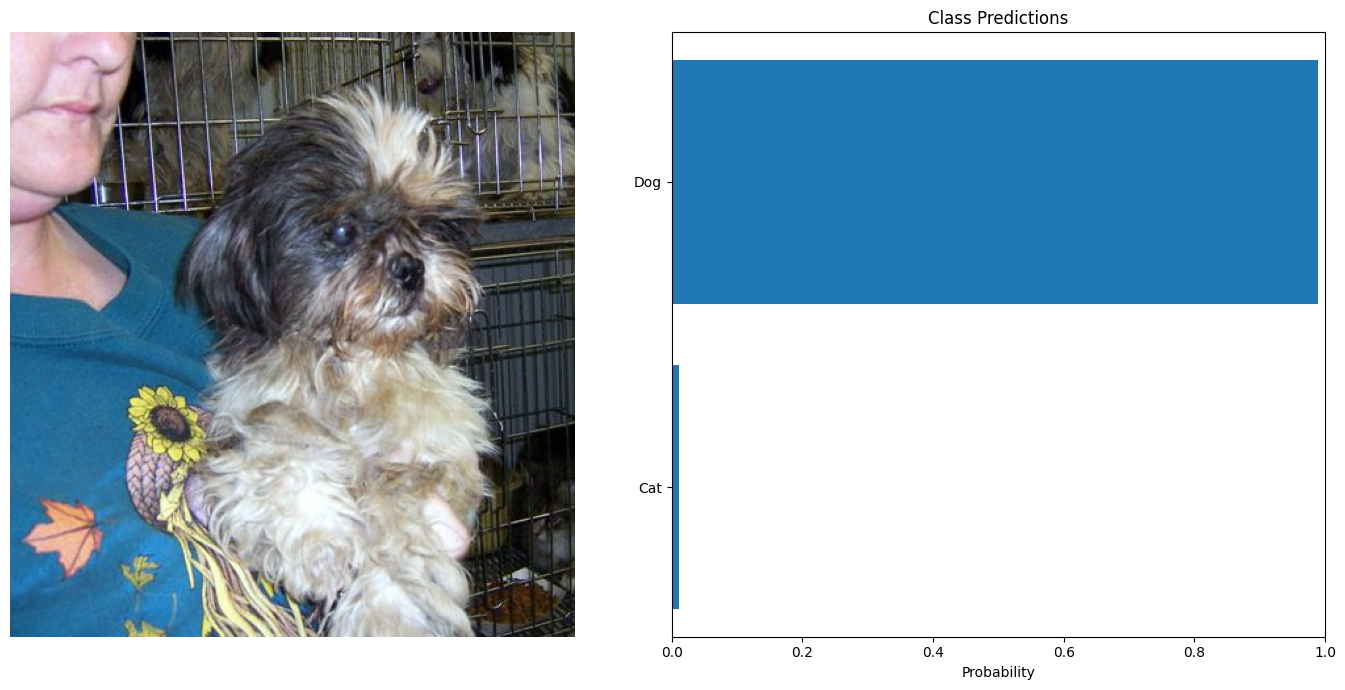

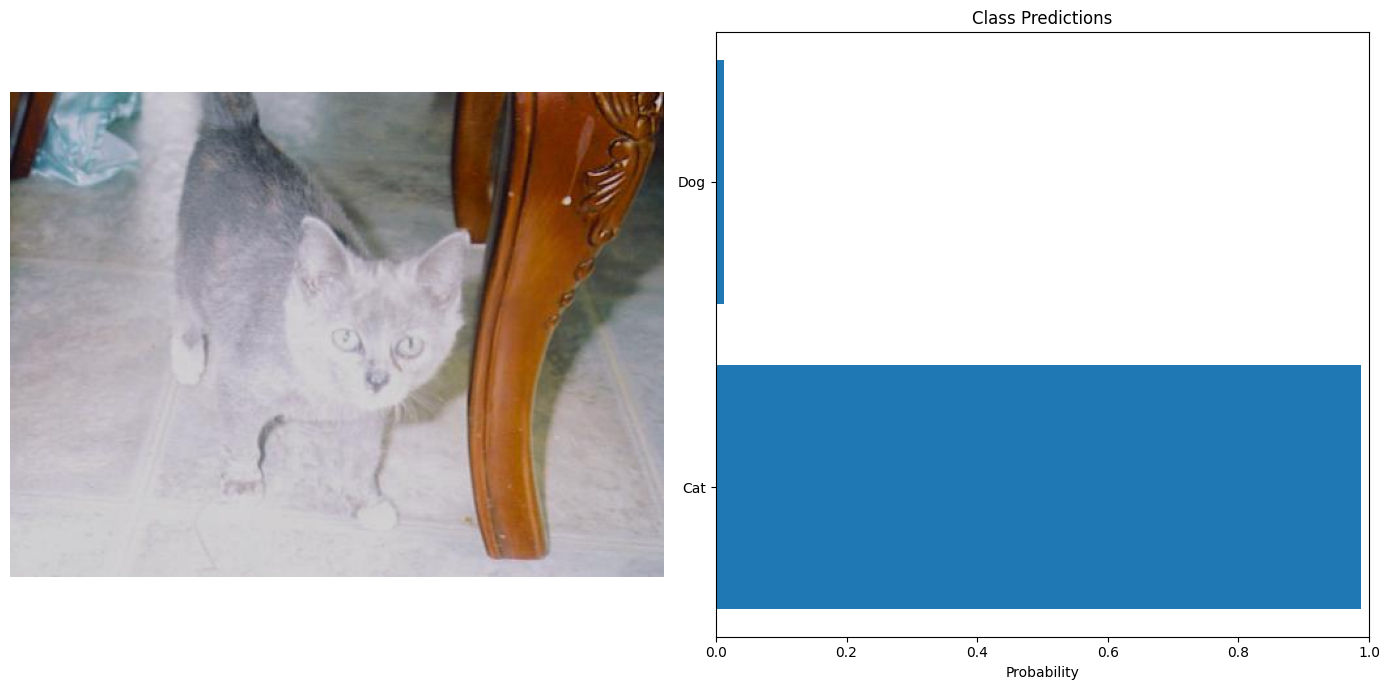

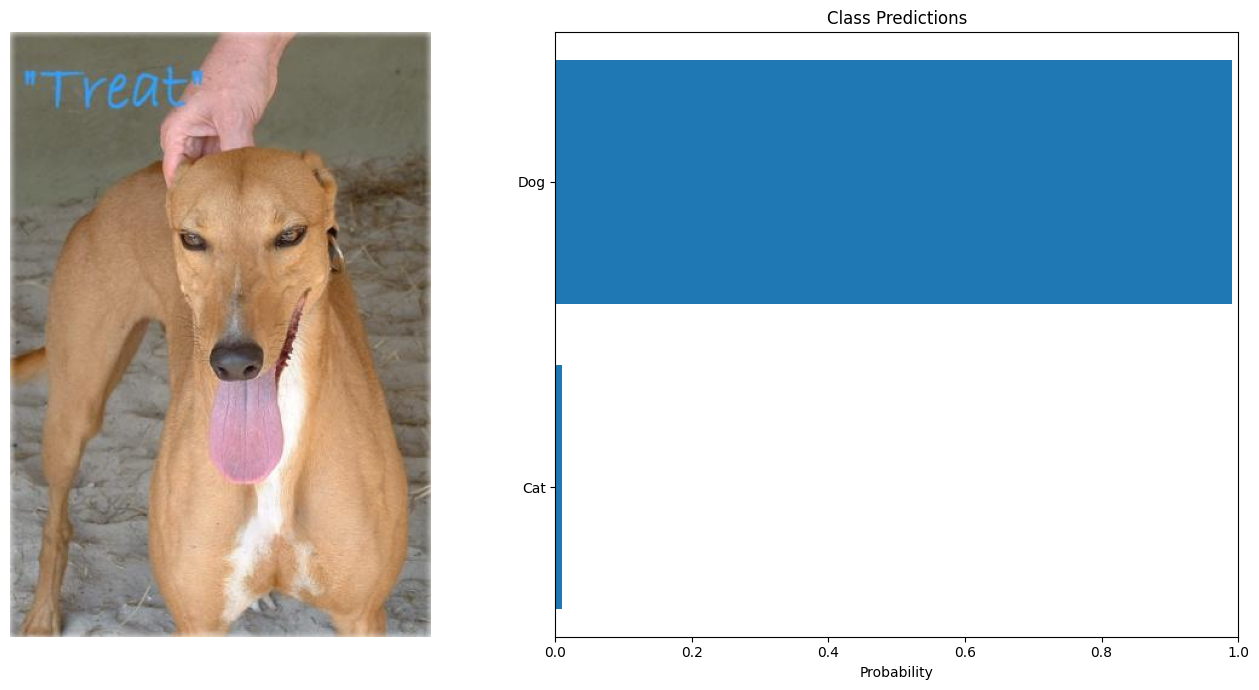

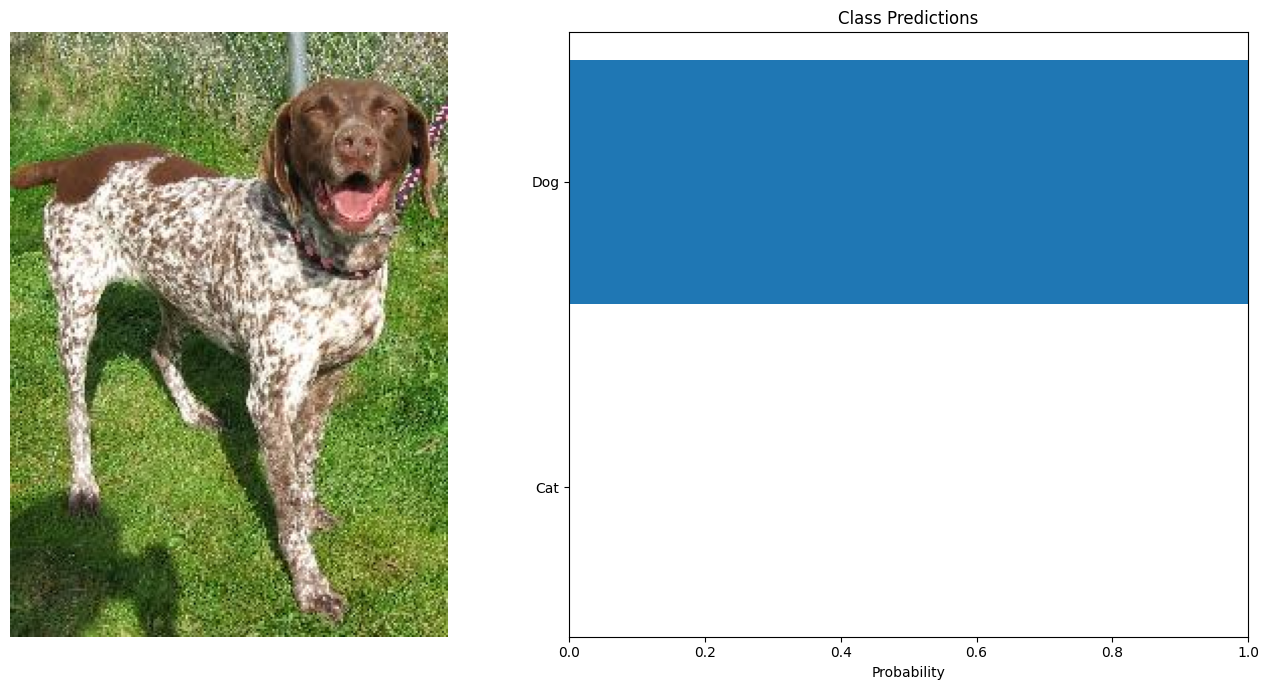

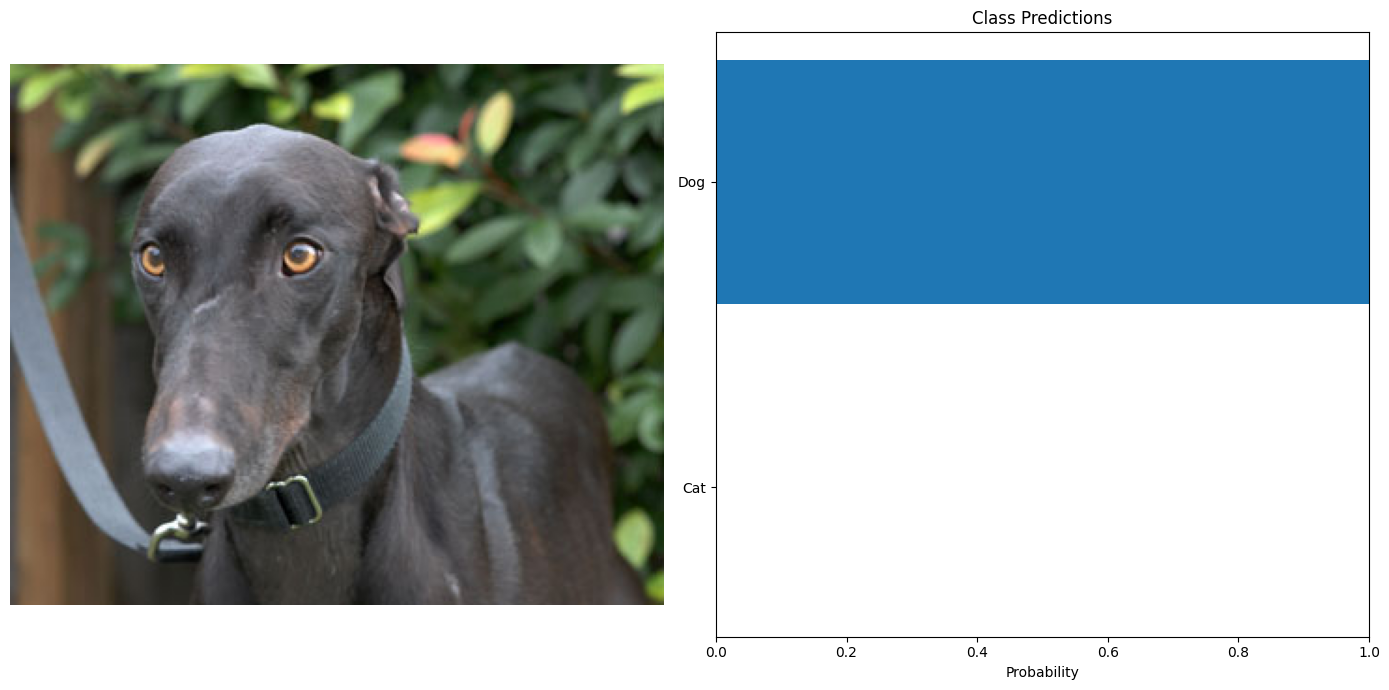

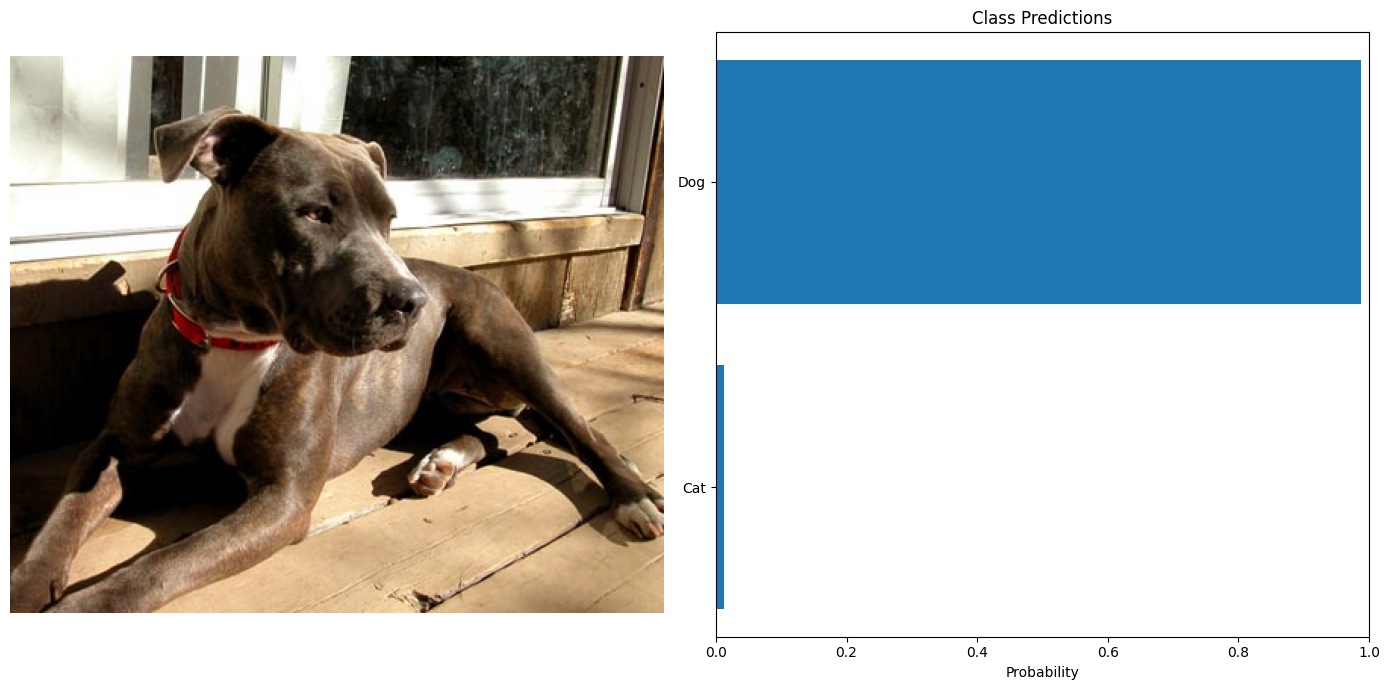

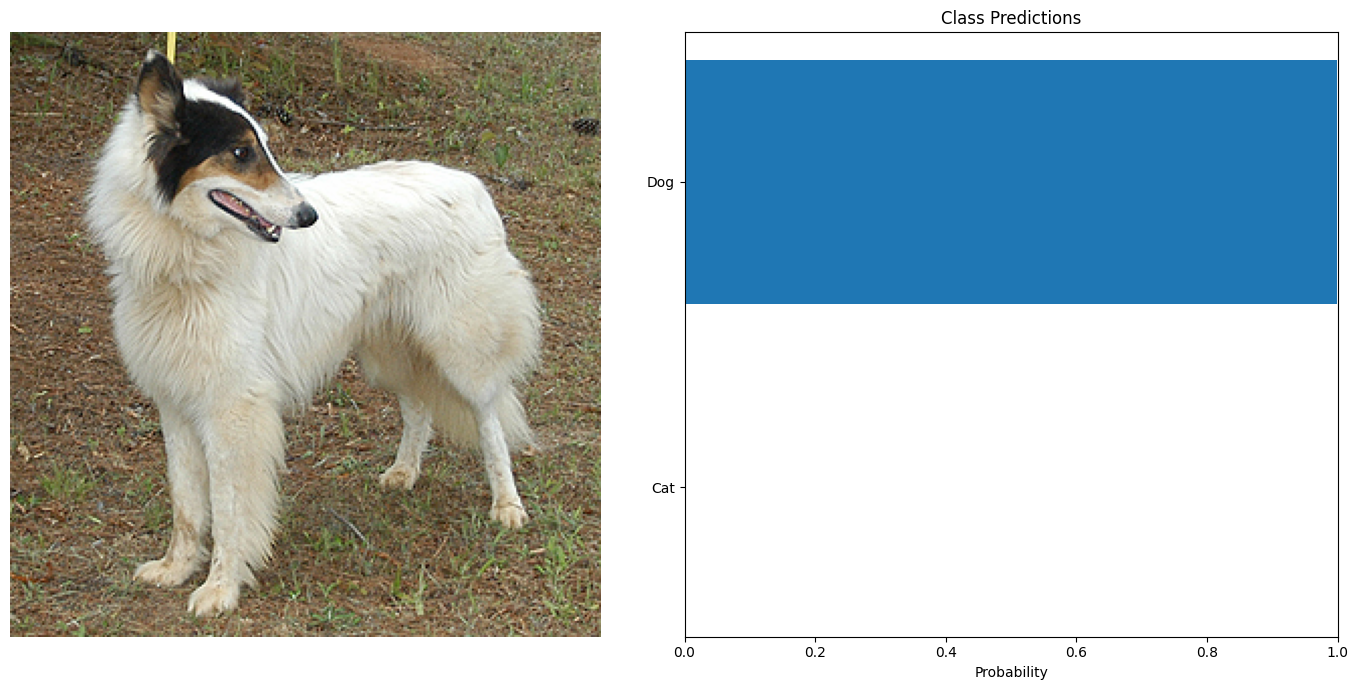

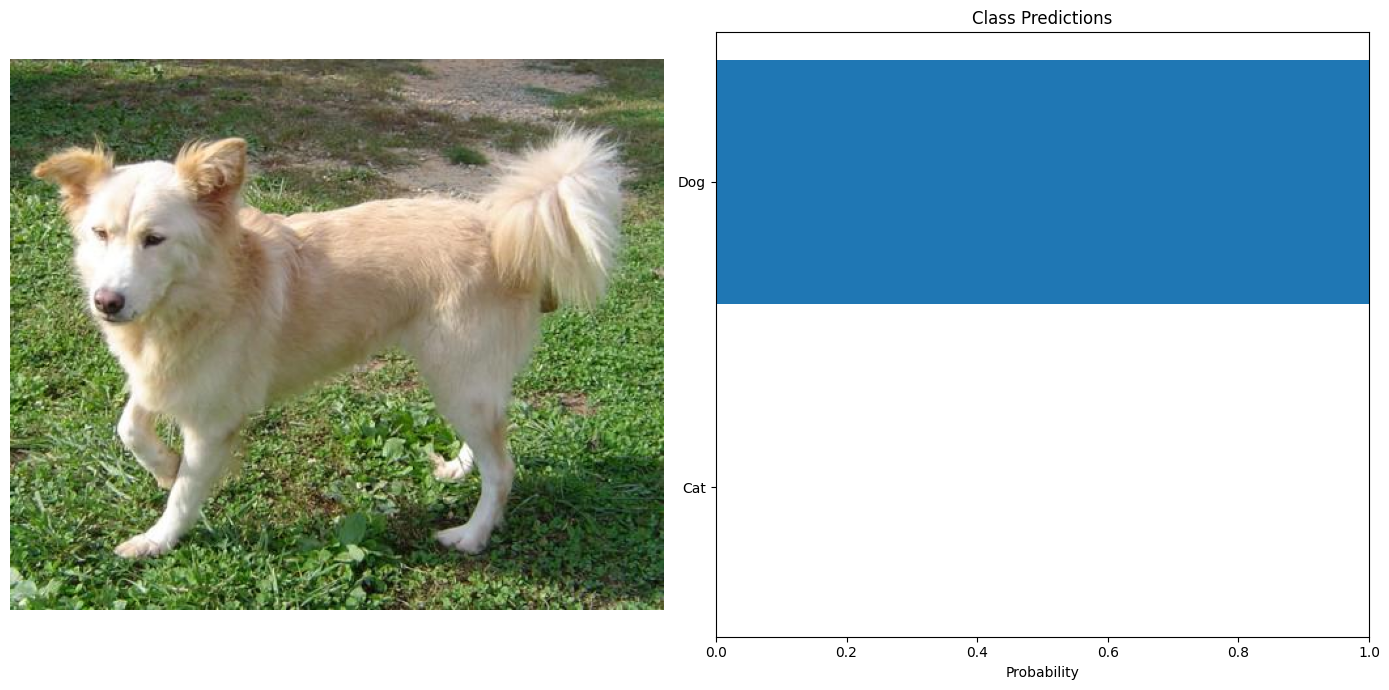

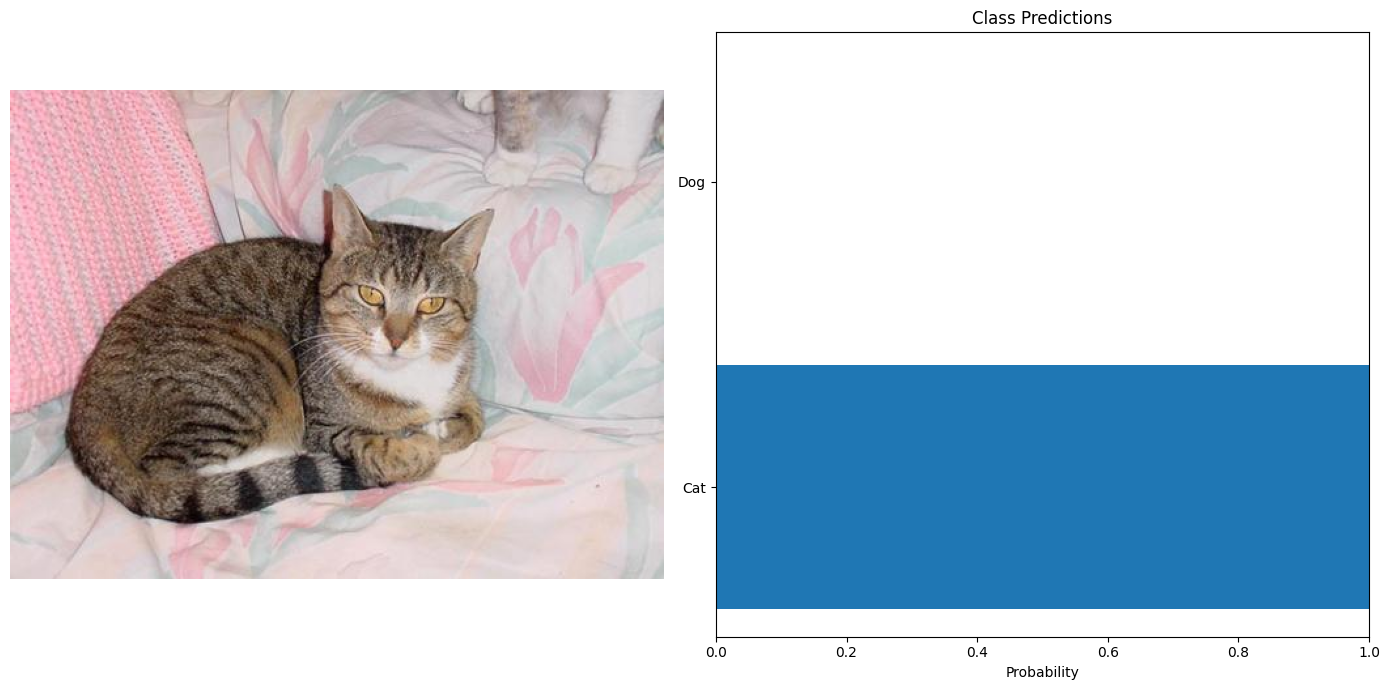

In [21]:
from glob import glob
test_images = glob('./test_data/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor)

    # Assuming dataset.classes gives the class names
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)

In [23]:
import joblib

joblib.dump(model, "cats_and_dogs_nn.joblib")


['cats_and_dogs_nn.joblib']